Stability analysis for alcohol

In [1]:
# set the data and knowledge files
data_file = 'canue_alcohol_global.csv'
knowledge_file = 'prior_run8.txt'
group = 'alcohol'  # used for plot file name

In [2]:
from pytetrad_plus import MyTetradSearch
from dgraph_flex import DgraphFlex
import semopy
import pprint as pp

# create the objects we will need
dgraph = DgraphFlex()
ts = MyTetradSearch()

In [3]:
# read the prior knowledge file
prior_lines = ts.read_prior_file(knowledge_file)
# extract knowledge from the prior lines
knowledge = ts.extract_knowledge(prior_lines)

pp.pprint(knowledge)

{'addtemporal': {0: ['Full_Education', 'Full_Age', 'Sex'],
                 1: ['FPQ_Total',
                     'UPPSP_NegativeUrgency',
                     'UPPSP_LackofPerseverance',
                     'UPPSP_LackofPremeditation',
                     'UPPSP_SensationSeeking',
                     'UPPSP_PositiveUrgency',
                     'GAD7_Total',
                     'PASS20_Total',
                     'PCS_Total',
                     'PHQ9_Total',
                     'PROMIS_Anger_Total',
                     'ASSIST_Alcohol_RiskScore',
                     'PROMIS_FU_Alc',
                     'FPQ_FU_Alc',
                     'UPPS_FU_Alc',
                     'PASS_FU_Alc',
                     'PCS_FU_Alc',
                     'GAD_FU_Alc',
                     'PHQ_FU_Alc',
                     'ReliefVAS_Alc',
                     'NumPainSites',
                     'BPI_PainLeast',
                     'BPI_PainWorst',
                     'BPI_PainAvera

In [4]:
# read in the data
df = ts.read_csv(data_file)

df

,Freq_SU_Pain_3,Full_Education,Full_Age,Sex,ASSIST_Alcohol_RiskScore,ReliefVAS_Alc,NumPainSites,BPI_PainLeast,BPI_PainWorst,BPI_PainAverage,BPI_PainRightNow,CANUE_Z_Total,AlcExpectMean
0,-0.906107,1.148545,-0.108377,-1.075922,-1.323779,-1.420007,-0.415025,-0.059433,0.073995,-0.355600,-0.186280,0.483871,-1.564709
1,2.095854,-1.137031,1.758914,0.929435,0.129495,1.518364,-0.178972,1.273405,1.293508,1.257163,1.047417,0.912887,1.247237
2,2.095854,1.148545,-0.186180,0.929435,0.583643,1.551012,1.001292,2.354084,1.150036,2.119804,2.006960,1.766415,1.559057
3,2.191661,0.005757,0.669661,-1.075922,1.037792,0.963338,-0.887131,1.921812,2.190209,1.594718,1.561458,2.249480,1.030077
4,1.808432,1.148545,0.202839,-1.075922,2.036918,1.420418,0.057081,2.101925,2.046737,1.932273,2.109768,1.665072,1.286215
...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,0.722617,1.148545,-0.808610,-1.075922,0.401984,0.310367,-0.415025,1.057269,0.719619,0.694572,0.773262,-0.666928,0.022231
393,0.243580,1.148545,-0.808610,-1.075922,0.492814,0.506258,0.057081,1.021246,0.755487,0.732078,1.081687,-0.486764,0.267232
394,0.818424,-1.137031,-1.119825,-1.075922,1.401110,-0.114064,-0.415025,0.264771,-0.069477,0.056968,0.122144,0.678673,-0.133679
395,1.169717,0.005757,-1.119825,0.929435,1.491940,0.604204,-0.415025,1.021246,1.042432,0.844596,1.458650,0.195608,0.618029


In [5]:
# standardize the data
df_std = ts.standardize_df_cols(df)
df_std

,Freq_SU_Pain_3,Full_Education,Full_Age,Sex,ASSIST_Alcohol_RiskScore,ReliefVAS_Alc,NumPainSites,BPI_PainLeast,BPI_PainWorst,BPI_PainAverage,BPI_PainRightNow,CANUE_Z_Total,AlcExpectMean
0,-0.906107,1.148545,-0.108377,-1.075922,-1.323779,-1.420007,-0.415025,-0.059433,0.073995,-0.355600,-0.186280,0.483871,-1.564709
1,2.095854,-1.137031,1.758914,0.929435,0.129495,1.518364,-0.178972,1.273405,1.293508,1.257163,1.047417,0.912887,1.247237
2,2.095854,1.148545,-0.186180,0.929435,0.583643,1.551012,1.001292,2.354084,1.150036,2.119804,2.006960,1.766415,1.559057
3,2.191661,0.005757,0.669661,-1.075922,1.037792,0.963338,-0.887131,1.921812,2.190209,1.594718,1.561458,2.249480,1.030077
4,1.808432,1.148545,0.202839,-1.075922,2.036918,1.420418,0.057081,2.101925,2.046737,1.932273,2.109768,1.665072,1.286215
...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,0.722617,1.148545,-0.808610,-1.075922,0.401984,0.310367,-0.415025,1.057269,0.719619,0.694572,0.773262,-0.666928,0.022231
393,0.243580,1.148545,-0.808610,-1.075922,0.492814,0.506258,0.057081,1.021246,0.755487,0.732078,1.081687,-0.486764,0.267232
394,0.818424,-1.137031,-1.119825,-1.075922,1.401110,-0.114064,-0.415025,0.264771,-0.069477,0.056968,0.122144,0.678673,-0.133679
395,1.169717,0.005757,-1.119825,0.929435,1.491940,0.604204,-0.415025,1.021246,1.042432,0.844596,1.458650,0.195608,0.618029


In [6]:
# Run the search
searchResult = ts.run_model_search( df_std, 
                                    model='gfci', 
                                    knowledge=knowledge, 
                                    score={'sem_bic': {'penalty_discount': 1.0}},
                                    test={'fisher_z': {'alpha': .05}})


pp.pprint(searchResult['setEdges'])
print(f"num edges: {len(searchResult['setEdges'])}")



adjacentNodes: [CANUE_Z_Total]
adjacentNodes: [ASSIST_Alcohol_RiskScore, Sex, Full_Age, BPI_PainAverage]
adjacentNodes: [BPI_PainLeast, BPI_PainWorst, BPI_PainAverage]
adjacentNodes: [BPI_PainRightNow, BPI_PainAverage]
adjacentNodes: [Freq_SU_Pain_3, BPI_PainRightNow, BPI_PainAverage]
adjacentNodes: [BPI_PainLeast, BPI_PainWorst, Freq_SU_Pain_3, CANUE_Z_Total, BPI_PainRightNow]
adjacentNodes: [BPI_PainLeast, BPI_PainWorst, Freq_SU_Pain_3, CANUE_Z_Total, BPI_PainRightNow]
adjacentNodes: [BPI_PainLeast, BPI_PainWorst, BPI_PainAverage]
adjacentNodes: [BPI_PainLeast, BPI_PainWorst, Freq_SU_Pain_3, CANUE_Z_Total, BPI_PainRightNow]
adjacentNodes: [BPI_PainRightNow, BPI_PainAverage]
adjacentNodes: [ASSIST_Alcohol_RiskScore, Sex, Full_Age, BPI_PainAverage]
adjacentNodes: [BPI_PainLeast, BPI_PainWorst, Freq_SU_Pain_3, CANUE_Z_Total, BPI_PainRightNow]
adjacentNodes: [Freq_SU_Pain_3, BPI_PainRightNow, BPI_PainAverage]
adjacentNodes: [BPI_PainLeast, BPI_PainWorst, BPI_PainAverage]
adjacentNodes: [

In [13]:
# Run the search with different parameters
# added max_degree and complete_rule_set_used
searchResult2 = ts.run_model_search( df_std, 
                                    model='gfci', 
                                    knowledge=knowledge, 
                                    score={'sem_bic': {'penalty_discount': 1.0}},
                                    test={'fisher_z': {'alpha': .05}},
                                    max_degree = 1000,
                                    complete_rule_set_used = True,
                                    )



pp.pprint(searchResult2['setEdges'])
print(f"num edges: {len(searchResult2['setEdges'])}")


adjacentNodes: [CANUE_Z_Total]
adjacentNodes: [ASSIST_Alcohol_RiskScore, Sex, Full_Age, BPI_PainAverage]
adjacentNodes: [BPI_PainLeast, BPI_PainWorst, BPI_PainAverage]
adjacentNodes: [BPI_PainRightNow, BPI_PainAverage]
adjacentNodes: [Freq_SU_Pain_3, BPI_PainRightNow, BPI_PainAverage]
adjacentNodes: [BPI_PainLeast, BPI_PainWorst, Freq_SU_Pain_3, CANUE_Z_Total, BPI_PainRightNow]
adjacentNodes: [BPI_PainLeast, BPI_PainWorst, Freq_SU_Pain_3, CANUE_Z_Total, BPI_PainRightNow]
adjacentNodes: [BPI_PainLeast, BPI_PainWorst, BPI_PainAverage]
adjacentNodes: [BPI_PainLeast, BPI_PainWorst, Freq_SU_Pain_3, CANUE_Z_Total, BPI_PainRightNow]
adjacentNodes: [BPI_PainRightNow, BPI_PainAverage]
adjacentNodes: [ASSIST_Alcohol_RiskScore, Sex, Full_Age, BPI_PainAverage]
adjacentNodes: [BPI_PainLeast, BPI_PainWorst, Freq_SU_Pain_3, CANUE_Z_Total, BPI_PainRightNow]
adjacentNodes: [Freq_SU_Pain_3, BPI_PainRightNow, BPI_PainAverage]
adjacentNodes: [BPI_PainLeast, BPI_PainWorst, BPI_PainAverage]
adjacentNodes: [

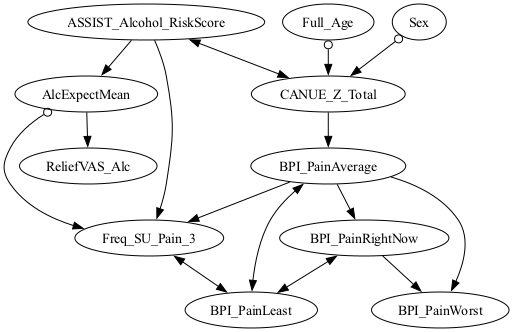

In [8]:
# display the graph
dgraph.add_edges(searchResult['setEdges'])
dgraph.show_graph()

In [9]:
# run the SEM

# convert the edges from searchResult to lavaan format
lavaan_model = ts.edges_to_lavaan(searchResult['setEdges'])

# run the SEM
sem_results = ts.run_semopy(lavaan_model, df_std)

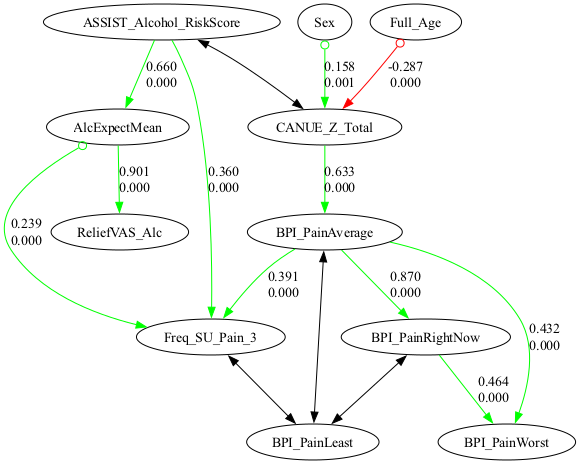

In [10]:
# add the sem results to our graph object

ts.add_sem_results_to_graph(dgraph, sem_results['estimates'])
# save the graph to a png file
dgraph.save_graph(plot_format='png', plot_name=f'{group}_single_sem')

# show the graph
dgraph.show_graph()

In [11]:
# run the stability search
stable_edges, sorted_edges, sorted_edges_raw, run_results = ts.run_stability_search(
                                        df_std, 
                                        model='gfci',
                                        knowledge=knowledge,
                                        score={'sem_bic': {'penalty_discount': 1.0}},
                                        test={'fisher_z': {'alpha': .05}},
                                        runs=100,
                                        min_fraction=0.75,
                                        subsample_fraction=0.9,
                                        lag_flag=False,
                                        save_file='stability_search_results.json',)

stable_edges

Running stability search with 100 runs:   0%|          | 0/100 [00:00<?, ?run/s]

adjacentNodes: [CANUE_Z_Total]
adjacentNodes: [ASSIST_Alcohol_RiskScore, Sex, Full_Age, BPI_PainAverage]
adjacentNodes: [BPI_PainLeast, BPI_PainWorst, BPI_PainAverage]
adjacentNodes: [BPI_PainRightNow, BPI_PainAverage]
adjacentNodes: [ASSIST_Alcohol_RiskScore, BPI_PainRightNow, BPI_PainAverage]
adjacentNodes: [AlcExpectMean, BPI_PainLeast, Freq_SU_Pain_3, CANUE_Z_Total, Full_Education]
adjacentNodes: [BPI_PainLeast, BPI_PainWorst, Freq_SU_Pain_3, CANUE_Z_Total, BPI_PainRightNow]
adjacentNodes: [ASSIST_Alcohol_RiskScore, BPI_PainRightNow, BPI_PainAverage]
adjacentNodes: [BPI_PainLeast, BPI_PainWorst, Freq_SU_Pain_3, CANUE_Z_Total, BPI_PainRightNow]
adjacentNodes: [BPI_PainLeast, BPI_PainWorst, BPI_PainAverage]
adjacentNodes: [BPI_PainLeast, BPI_PainWorst, Freq_SU_Pain_3, CANUE_Z_Total, BPI_PainRightNow]
adjacentNodes: [BPI_PainRightNow, BPI_PainAverage]
adjacentNodes: [ASSIST_Alcohol_RiskScore, Sex, Full_Age, BPI_PainAverage]
adjacentNodes: [BPI_PainLeast, BPI_PainWorst, Freq_SU_Pain_3,

['Full_Age o-> CANUE_Z_Total',
 'ASSIST_Alcohol_RiskScore --> Freq_SU_Pain_3',
 'BPI_PainAverage --> BPI_PainRightNow',
 'BPI_PainAverage --> BPI_PainWorst',
 'BPI_PainAverage --> Freq_SU_Pain_3']

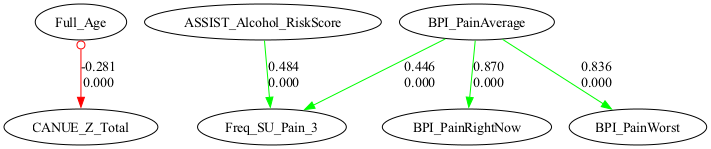

In [12]:
# lets create the new graph with the stable edges
dgraph = DgraphFlex()
dgraph.add_edges(stable_edges)

lavaan_model = ts.edges_to_lavaan(stable_edges)

# run semopy, using the lagged and standardized data
sem_results = ts.run_semopy(lavaan_model, df_std)
# add the semopy results to the graph object
ts.add_sem_results_to_graph(dgraph, sem_results['estimates'])
# save the graph to a png file
dgraph.save_graph(plot_format='png', plot_name=f'{group}_stable_sem')
# show the graph
dgraph.show_graph()